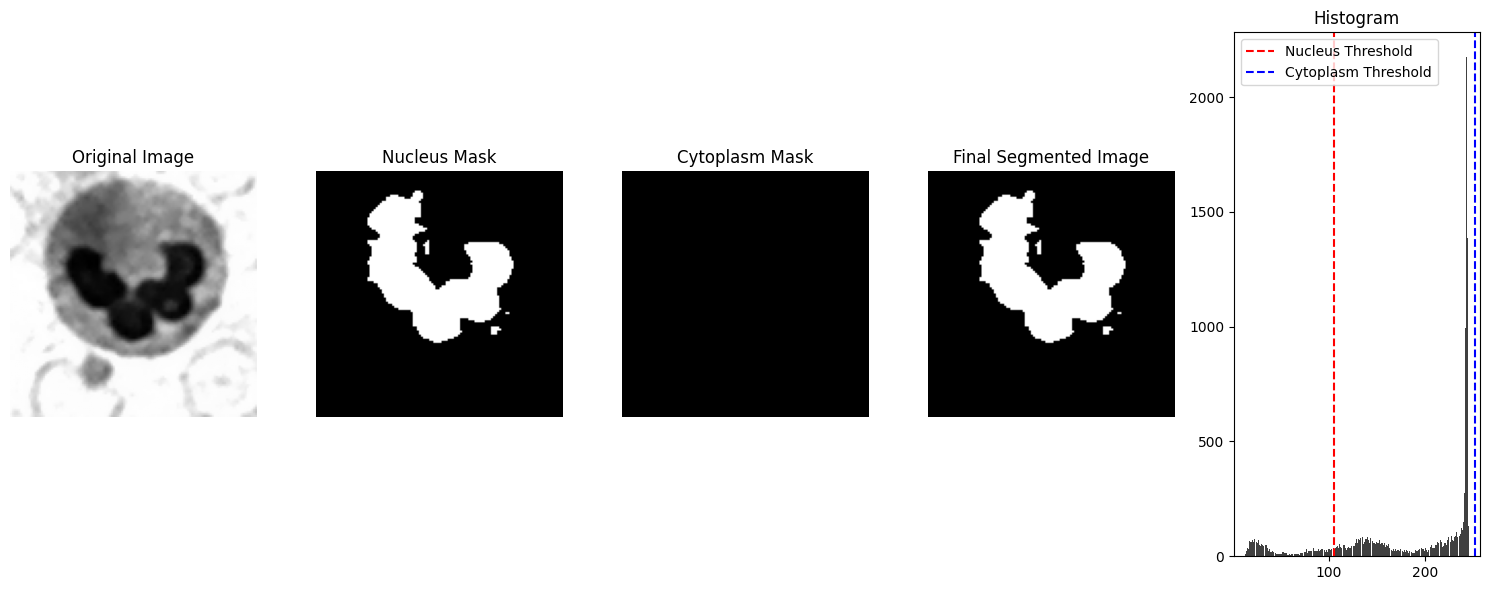

In [163]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    """Load grayscale image."""
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def compute_thresholds(img, k1=1.0, k2=1.0):
    """Compute dynamic thresholds based on mean and standard deviation."""
    valid_pixels = img[img < 255]  # Ignore white background
    mean_intensity = np.mean(valid_pixels)
    std_dev_intensity = np.std(valid_pixels)
    nucleus_thresh = mean_intensity - k1 * std_dev_intensity
    cytoplasm_thresh = mean_intensity + k2 * std_dev_intensity
    return nucleus_thresh, cytoplasm_thresh

def manual_thresholding(img, nucleus_thresh, cytoplasm_thresh):
    """Apply manual thresholding to segment nucleus and cytoplasm."""
    nucleus_mask = img <= nucleus_thresh  # Nucleus condition
    cytoplasm_mask = img >= cytoplasm_thresh  # Cytoplasm condition
    
    nucleus_only = np.zeros_like(img)
    nucleus_only[nucleus_mask] = 255  # Nucleus is White
    
    cytoplasm_only = np.zeros_like(img)
    cytoplasm_only[cytoplasm_mask] = 128  # Cytoplasm is Gray
    
    segmented = np.zeros_like(img)
    segmented[nucleus_only == 255] = 255  # Nucleus White
    segmented[cytoplasm_only == 128] = 128  # Cytoplasm Gray
    segmented[segmented == 128] = 1
    segmented[segmented == 0] = 128
    segmented[segmented == 1] = 0
    
    return nucleus_only, cytoplasm_only, segmented

def plot_results(img, nucleus_only, cytoplasm_only, segmented, nucleus_thresh, cytoplasm_thresh):
    """Plot original image, segmented masks, and histogram."""
    valid_pixels = img[img < 255]
    fig, axes = plt.subplots(1, 5, figsize=(15, 6))
    
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(nucleus_only, cmap="gray")
    axes[1].set_title("Nucleus Mask")
    axes[1].axis("off")
    
    axes[2].imshow(cytoplasm_only, cmap="gray")
    axes[2].set_title("Cytoplasm Mask")
    axes[2].axis("off")
    
    axes[3].imshow(segmented, cmap="gray")
    axes[3].set_title("Final Segmented Image")
    axes[3].axis("off")
    
    axes[4].hist(valid_pixels.ravel(), bins=256, color="black", alpha=0.75)
    axes[4].axvline(nucleus_thresh, color='red', linestyle='dashed', label="Nucleus Threshold")
    axes[4].axvline(cytoplasm_thresh, color='blue', linestyle='dashed', label="Cytoplasm Threshold")
    axes[4].set_title("Histogram")
    axes[4].legend()
    
    plt.tight_layout()
    plt.show()

def main():
    image_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train\\images\\003.bmp"
    img = load_image(image_path)
    
    nucleus_thresh, cytoplasm_thresh = compute_thresholds(img)
    nucleus_only, cytoplasm_only, segmented = manual_thresholding(img, nucleus_thresh, cytoplasm_thresh)
    
    plot_results(img, nucleus_only, cytoplasm_only, segmented, nucleus_thresh, cytoplasm_thresh)

if __name__ == "__main__":
    main()


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

def compute_accuracy(pred_mask, gt_mask):
    """Compute accuracy between predicted and ground truth masks without binarization."""
    TP_TN = np.sum(pred_mask == gt_mask)  # Pixels where both match
    total_pixels = pred_mask.size  # Total number of pixels
    return TP_TN / total_pixels if total_pixels != 0 else 1.0

def create_combined_mask(img_cyto, img_nuc):
    """Create a combined mask with cytoplasm (gray) and nucleus (white)."""
    combined_mask = np.zeros_like(img_cyto, dtype=np.uint8)
    combined_mask[img_cyto > 0] = 128  # Gray for cytoplasm
    combined_mask[img_nuc > 0] = 255   # White for nucleus
    return combined_mask

def dice_coefficient(mask1, mask2):
    """Compute the Dice coefficient between two binary masks."""
    intersection = np.sum((mask1 > 0) & (mask2 > 0))
    sum_masks = np.sum(mask1 > 0) + np.sum(mask2 > 0)
    return (2. * intersection) / sum_masks if sum_masks != 0 else 1.0

def connectivit_8(image, limit, padd_size):
    """Perform 8-connectivity labeling."""
    height, width = image.shape
    connect_8 = np.zeros((height, width), dtype=np.int32)
    eq_list = {}
    label = 1

    for i in range(padd_size, height - padd_size):
        for j in range(padd_size, width - padd_size):
            if 0 <= image[i, j] <= limit:
                neighbors = []
                if connect_8[i, j - padd_size] > 0:
                    neighbors.append(connect_8[i, j - padd_size])
                if connect_8[i - padd_size, j] > 0:
                    neighbors.append(connect_8[i - padd_size, j])
                if connect_8[i - padd_size, j - padd_size] > 0:
                    neighbors.append(connect_8[i - padd_size, j - padd_size])
                if connect_8[i - padd_size, j + padd_size] > 0:
                    neighbors.append(connect_8[i - padd_size, j + padd_size])
                if not neighbors:
                    connect_8[i, j] = label
                    eq_list[label] = label
                    label += 1
                else:
                    min_label = min(neighbors)
                    connect_8[i, j] = min_label
                    for neighbor in neighbors:
                        eq_list[neighbor] = min_label

    for i in range(height):
        for j in range(width):
            if connect_8[i, j] > 0:
                connect_8[i, j] = eq_list[connect_8[i, j]]
    return connect_8

def test_v_set(img, v_set_values):
    """Test different V set values and select the best one based on Dice Score."""
    best_v_set = (1.5, 1.5)  # Default V set to prevent NoneType errors
    best_dice = 0

    valid_pixels = img[img < 255]
    
    if valid_pixels.size == 0:
        print("Warning: No valid pixels found in image, using default V set.")
        return best_v_set  # Use default values if image is empty

    mean_intensity = np.mean(valid_pixels)
    std_dev_intensity = np.std(valid_pixels)

    for k1, k2 in v_set_values:
        nucleus_thresh = mean_intensity - k1 * std_dev_intensity
        cytoplasm_thresh = mean_intensity - k2 * std_dev_intensity

        img_cyto = connectivit_8(img, cytoplasm_thresh, 1)
        img_nuc = connectivit_8(img, nucleus_thresh, 1)
        combined_mask = create_combined_mask(img_cyto, img_nuc)

        # Use a dummy mask (for testing) OR replace with real ground truth later
        dummy_mask = np.zeros_like(img)  
        dice_score = dice_coefficient(combined_mask, dummy_mask)

        if dice_score > best_dice:
            best_dice = dice_score
            best_v_set = (k1, k2)

    return best_v_set  # Ensure function always returns a valid tuple

def process_dataset(train_images_path, train_masks_path, output_csv):
    """Process all images in the dataset and store results in a DataFrame."""
    
    results = []
    v_set_values = [(1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (1.0, 2.0), (2.0, 1.0)]

    if not os.path.exists(train_images_path) or not os.path.exists(train_masks_path):
        print("Error: One or more specified directories do not exist!")
        return

    for filename in os.listdir(train_images_path):
        if filename.endswith(".bmp"):
            img_path = os.path.join(train_images_path, filename)
            mask_filename = filename.replace(".bmp", ".png")
            mask_path = os.path.join(train_masks_path, mask_filename)

            if not os.path.exists(mask_path):
                print(f"Mask not found for {filename}, skipping...")
                continue

            img = cv2.imread(img_path, 0)
            if img is None:
                print(f"Failed to read {filename}, skipping...")
                continue

            # Find the best V set
            best_v_set = test_v_set(img, v_set_values)
            best_k1, best_k2 = best_v_set  # Unpack without error

            nucleus_thresh = np.mean(img) - best_k1 * np.std(img)
            cytoplasm_thresh = np.mean(img) - best_k2 * np.std(img)

            # Generate segmented images
            img_cyto = connectivit_8(img, cytoplasm_thresh, 1)
            img_nuc = connectivit_8(img, nucleus_thresh, 1)

            # Create combined mask
            combined_mask = create_combined_mask(img_cyto, img_nuc)

            # Read and process ground truth mask
            ground_truth_mask = cv2.imread(mask_path, 0)
            if ground_truth_mask is None:
                print(f"Failed to read mask {mask_filename}, skipping...")
                continue

            # Compute Dice coefficient
            dice_score = dice_coefficient(combined_mask, ground_truth_mask)

            # Compute Accuracy
            accuracy = compute_accuracy(combined_mask, ground_truth_mask)

            # Store results
            results.append({
                "Image": filename,
                "Best_k1": best_k1,
                "Best_k2": best_k2,
                "Nucleus_Threshold": round(nucleus_thresh, 2),
                "Cytoplasm_Threshold": round(cytoplasm_thresh, 2),
                "Dice_Score": round(dice_score, 4),
                "Accuracy": round(accuracy, 4)
            })

            print(f"{filename}: Best (k1, k2) = ({best_k1}, {best_k2}), Dice Score = {dice_score:.4f}, Accuracy = {accuracy:.4f}")

    # Save results
    df_results = pd.DataFrame(results)
    df_results.to_csv(output_csv, index=False)
    return df_results

# Define dataset paths
train_images_path = r"E:\2. DIP\2. LAB\pythonProject\Assignment\dataset_DIP_assignment\train\images"
train_masks_path = r"E:\2. DIP\2. LAB\pythonProject\Assignment\dataset_DIP_assignment\train\masks"
output_csv = r"E:\2. DIP\2. LAB\pythonProject\Assignment\dataset_DIP_assignment\results.csv"

# Run the processing
df_train = process_dataset(train_images_path, train_masks_path, output_csv)


Number of labels: 10
Equivalence list: {1: np.int32(1), 2: np.int32(1), 3: 3, 4: np.int32(4), 5: np.int32(5), 6: np.int32(6), 7: np.int32(7), 8: np.int32(7), 9: np.int32(7), 10: np.int32(10), 11: np.int32(7), 12: np.int32(7), 13: np.int32(7), 14: np.int32(7), 15: np.int32(15), 16: np.int32(7), 17: 17, 18: np.int32(7), 19: np.int32(19)}
Unique Vals: {np.int32(1), 3, np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(10), np.int32(15), 17, np.int32(19)}
Number of labels: 2
Equivalence list: {1: np.int32(1), 2: np.int32(2), 3: np.int32(1), 4: np.int32(2), 5: np.int32(2), 6: np.int32(1), 7: np.int32(1), 8: np.int32(1), 9: np.int32(1), 10: np.int32(1)}
Unique Vals: {np.int32(1), np.int32(2)}


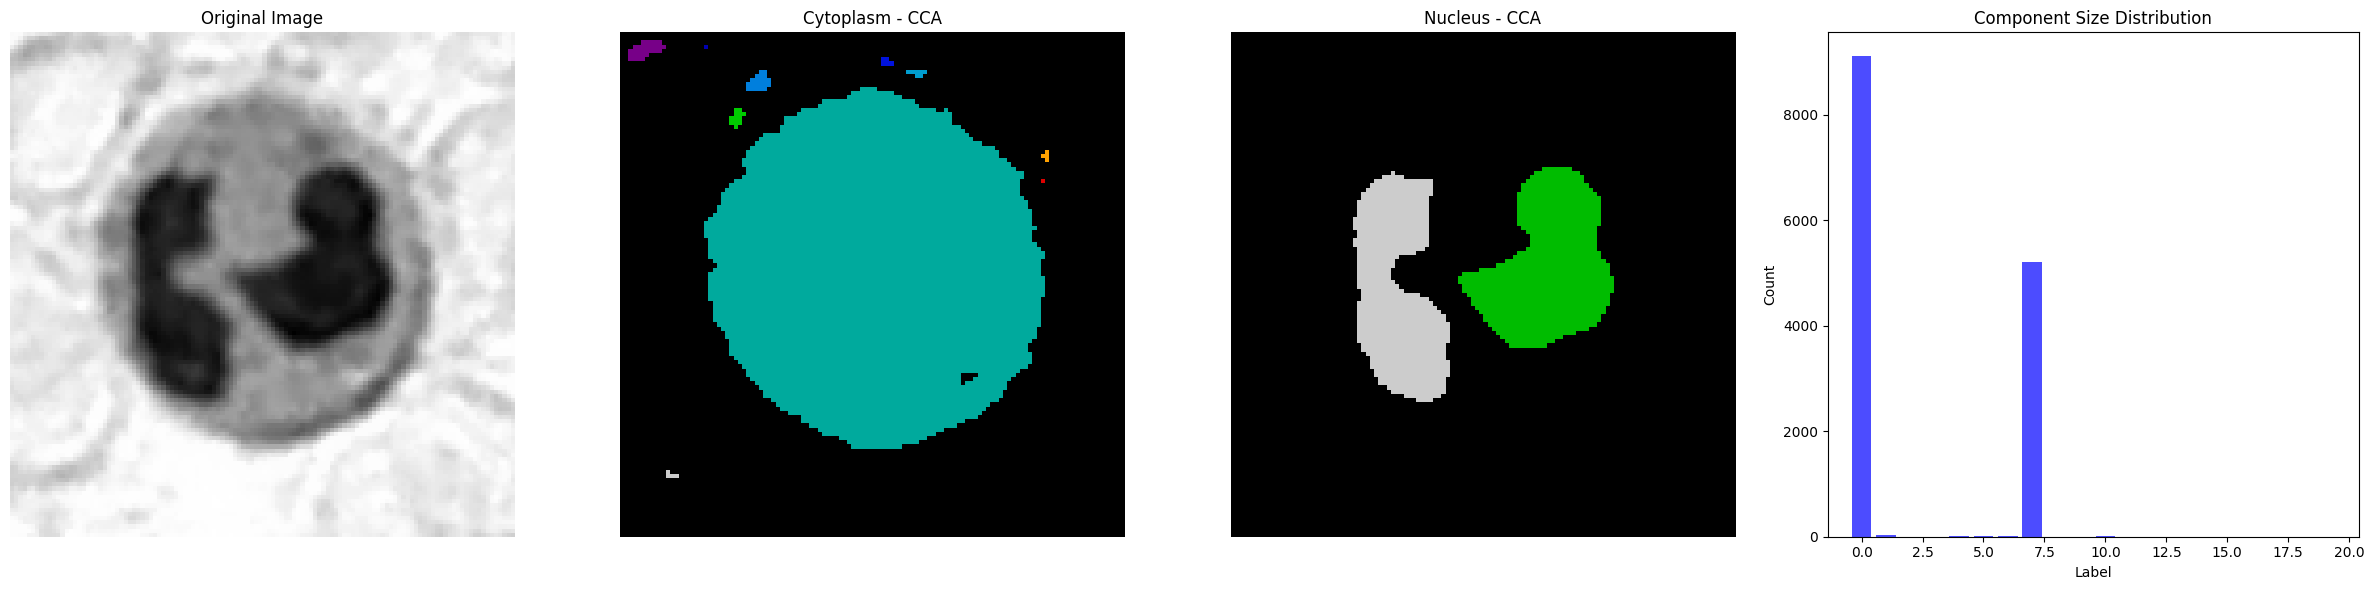

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def find_root(eq_list, key):
    if key not in eq_list:
        eq_list[key] = key
        return key
    while eq_list[key] != key:
        eq_list[key] = eq_list[eq_list[key]]  # Path compression
        key = eq_list[key]
    return key

def connectivity_8(image, limit, padd_size):
    height, width = image.shape
    connect_8 = np.zeros((height, width), dtype=np.int32)  # Changed dtype to int32
    eq_list = {}
    label = 1

    for i in range(padd_size, height - padd_size):
        for j in range(padd_size, width - padd_size):
            if 0 <= image[i, j] <= limit:  # Foreground pixel condition
                neighbors = []
                if connect_8[i, j - padd_size] > 0:
                    neighbors.append(connect_8[i, j - padd_size])
                if connect_8[i - padd_size, j] > 0:
                    neighbors.append(connect_8[i - padd_size, j])
                if connect_8[i - padd_size, j - padd_size] > 0:
                    neighbors.append(connect_8[i - padd_size, j - padd_size])
                if connect_8[i - padd_size, j + padd_size] > 0:
                    neighbors.append(connect_8[i - padd_size, j + padd_size])

                if not neighbors:
                    connect_8[i, j] = label
                    eq_list[label] = label
                    label += 1
                else:
                    min_label = min(neighbors)
                    connect_8[i, j] = min_label
                    for neighbor in neighbors:
                        eq_list[find_root(eq_list, neighbor)] = find_root(eq_list, min_label)

    for i in range(height):
        for j in range(width):
            if connect_8[i, j] > 0:
                connect_8[i, j] = find_root(eq_list, connect_8[i, j])

    unique_labels = set(find_root(eq_list, lbl) for lbl in eq_list.values())
    print("Number of labels:", len(unique_labels))
    print("Equivalence list:", eq_list)
    print(f"Unique Vals: {unique_labels}")
    
    return connect_8

def plot_cca_results(original, img_cyto, img_nuc):
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # Added one more column
    
    # Original Image
    axes[0].imshow(original, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Cytoplasm Connected Component Analysis
    axes[1].imshow(img_cyto, cmap="nipy_spectral", interpolation="nearest")
    axes[1].set_title("Cytoplasm - CCA")
    axes[1].axis("off")
    
    # Nucleus Connected Component Analysis
    axes[2].imshow(img_nuc, cmap="nipy_spectral", interpolation="nearest")
    axes[2].set_title("Nucleus - CCA")
    axes[2].axis("off")
    
    # Histogram of unique labels
    unique, counts = np.unique(img_cyto, return_counts=True)
    axes[3].bar(unique, counts, color="blue", alpha=0.7)
    axes[3].set_title("Component Size Distribution")
    axes[3].set_xlabel("Label")
    axes[3].set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()

def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Error loading image. Check file path.")
    return img

def compute_thresholds(img, k1=1.5, k2=1.5):
    valid_pixels = img[img < 255]  # Ignore white background
    mean_intensity = np.mean(valid_pixels)
    std_dev_intensity = np.std(valid_pixels)
    nucleus_thresh = mean_intensity - k1 * std_dev_intensity
    cytoplasm_thresh = mean_intensity  # + k2 * std_dev_intensity
    return nucleus_thresh, cytoplasm_thresh

def process_image(image_path):
    img = load_image(image_path)
    nucleus_thresh, cytoplasm_thresh = compute_thresholds(img)
    img_cyto = connectivity_8(img, cytoplasm_thresh, 1)
    img_nuc = connectivity_8(img, nucleus_thresh, 1)
    
    
    plot_cca_results(img, img_cyto, img_nuc)

# Run the processing
image_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train\\images\\006.bmp"
process_image(image_path)


[  0 128 255]
Dice Coefficient: 0.3989


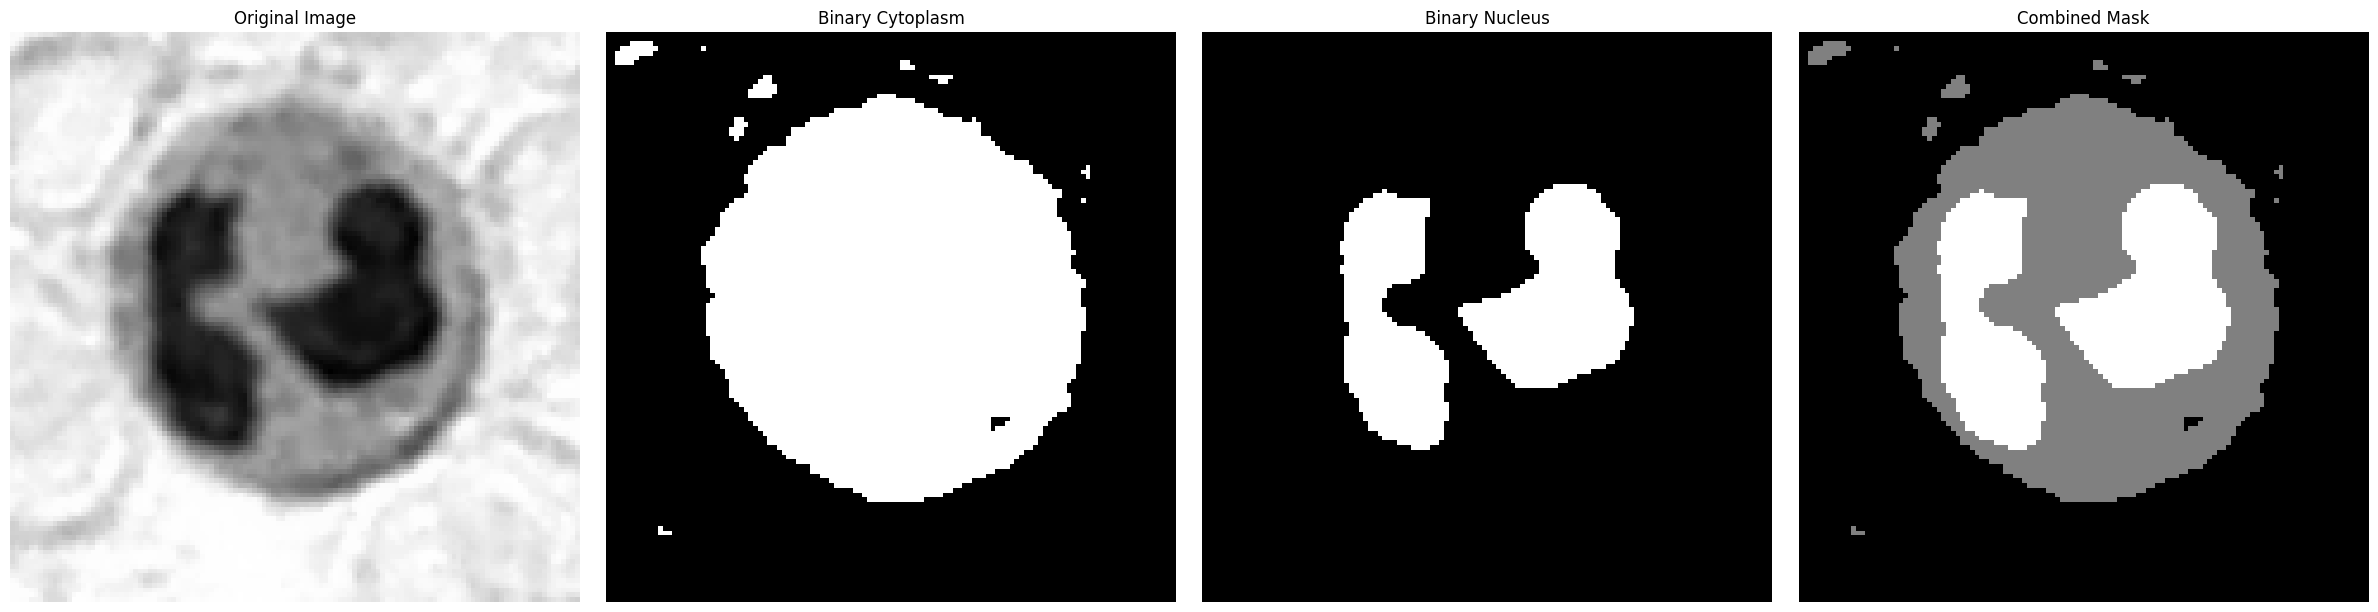

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def binarize_image(label_img):
    return np.where(label_img > 0, 255, 0).astype(np.uint8)

def create_combined_mask(img_cyto, img_nuc):
    combined_mask = np.zeros_like(img_cyto, dtype=np.uint8)
    combined_mask[img_cyto > 0] = 128  # Grey for cytoplasm
    combined_mask[img_nuc > 0] = 255   # White for nucleus
    return combined_mask

def plot_results(original, binary_cyto, binary_nuc, combined_mask):
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    
    axes[0].imshow(original, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(binary_cyto, cmap="gray")
    axes[1].set_title("Binary Cytoplasm")
    axes[1].axis("off")
    
    axes[2].imshow(binary_nuc, cmap="gray")
    axes[2].set_title("Binary Nucleus")
    axes[2].axis("off")
    
    axes[3].imshow(combined_mask, cmap="gray")
    axes[3].set_title("Combined Mask")
    axes[3].axis("off")
    
    plt.tight_layout()
    plt.show()

# Load and process the image
image_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train\\images\\006.bmp"
img = cv2.imread(image_path, 0)

if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

k1 = k2 = 1.5
valid_pixels = img[img < 255]
mean_intensity = np.mean(valid_pixels)
std_dev_intensity = np.std(valid_pixels)

nucleus_thresh = mean_intensity - k1 * std_dev_intensity
cytoplasm_thresh = mean_intensity #- 0.2*std_dev_intensity

def connectivit_8(image, limit, padd_size):
    height, width = image.shape
    connect_8 = np.zeros((height, width), dtype=np.int32)
    eq_list = {}
    label = 1

    for i in range(padd_size, height - padd_size):
        for j in range(padd_size, width - padd_size):
            if 0 <= image[i, j] <= limit:
                neighbors = []
                if connect_8[i, j - padd_size] > 0:
                    neighbors.append(connect_8[i, j - padd_size])
                if connect_8[i - padd_size, j] > 0:
                    neighbors.append(connect_8[i - padd_size, j])
                if connect_8[i - padd_size, j - padd_size] > 0:
                    neighbors.append(connect_8[i - padd_size, j - padd_size])
                if connect_8[i - padd_size, j + padd_size] > 0:
                    neighbors.append(connect_8[i - padd_size, j + padd_size])
                if not neighbors:
                    connect_8[i, j] = label
                    eq_list[label] = label
                    label += 1
                else:
                    min_label = min(neighbors)
                    connect_8[i, j] = min_label
                    for neighbor in neighbors:
                        eq_list[neighbor] = min_label

    for i in range(height):
        for j in range(width):
            if connect_8[i, j] > 0:
                connect_8[i, j] = eq_list[connect_8[i, j]]
    return connect_8

img_cyto = connectivit_8(img, cytoplasm_thresh, 1)
img_nuc = connectivit_8(img, nucleus_thresh, 1)

binary_cyto = binarize_image(img_cyto)
binary_nuc = binarize_image(img_nuc)
combined_mask = create_combined_mask(img_cyto, img_nuc)
print(np.unique(combined_mask))


def dice_coefficient(mask1, mask2):
    intersection = np.sum((mask1 > 0) & (mask2 > 0))
    sum_masks = np.sum(mask1 > 0) + np.sum(mask2 > 0)
    dice = (2. * intersection) / sum_masks if sum_masks != 0 else 1.0
    return dice

# Load the generated combined mask and ground truth mask
generated_mask = cv2.imread("E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train\\images\\007.bmp", 0)
ground_truth_mask = cv2.imread("E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train\\masks\\007.png", 0)

# Binarize the masks
generated_mask = np.where(generated_mask > 0, 255, 0).astype(np.uint8)
ground_truth_mask = np.where(ground_truth_mask > 0, 255, 0).astype(np.uint8)

# Compute Dice coefficient
dice_score = dice_coefficient(generated_mask, ground_truth_mask)
print(f"Dice Coefficient: {dice_score:.4f}")

plot_results(img, binary_cyto, binary_nuc, combined_mask)



In [176]:
import cv2
import numpy as np

def dice_coefficient(mask1, mask2):
    intersection = np.sum((mask1 > 0) & (mask2 > 0))
    sum_masks = np.sum(mask1 > 0) + np.sum(mask2 > 0)
    dice = (2. * intersection) / sum_masks if sum_masks != 0 else 1.0
    return dice

# Load the generated combined mask and ground truth mask
generated_mask = cv2.imread("E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train\\images\\006.bmp", 0)
ground_truth_mask = cv2.imread("E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train\\masks\\006.png", 0)

# Binarize the masks
generated_mask = np.where(generated_mask > 0, 255, 0).astype(np.uint8)
ground_truth_mask = np.where(ground_truth_mask > 0, 255, 0).astype(np.uint8)

# Compute Dice coefficient
dice_score = dice_coefficient(generated_mask, ground_truth_mask)
print(f"Dice Coefficient: {dice_score:.4f}")


Dice Coefficient: 0.5313


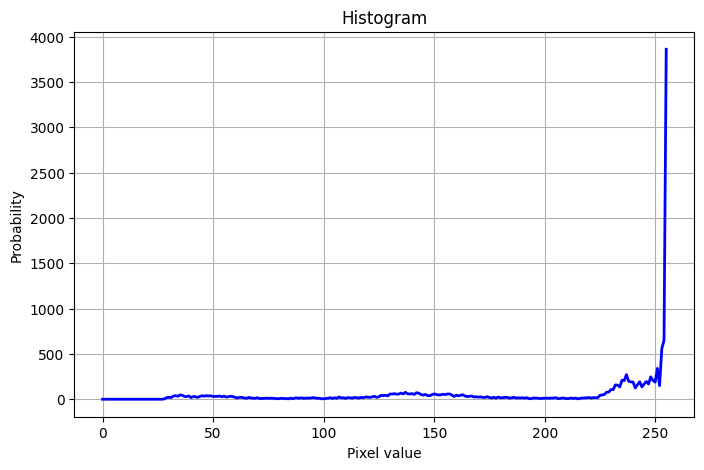

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
def histogram(img):
    array = [0] * 256
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel_val = int(img[i, j])
            array[pixel_val] += 1
    array = np.array(array)
    return array
train_images_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\images\\241.bmp"
img= cv2.imread(train_images_path, 0)
hist = histogram(img)
plt.figure(figsize=(8, 5))
plt.plot(range(256), hist, color='blue', linewidth=2)
plt.title("Histogram")
plt.xlabel("Pixel value")
plt.ylabel("Probability")
plt.grid()
plt.show()

Nucles :  [  0 255]
Cytoplasam :  [  0 128]
Combined :  [  0 128 255]


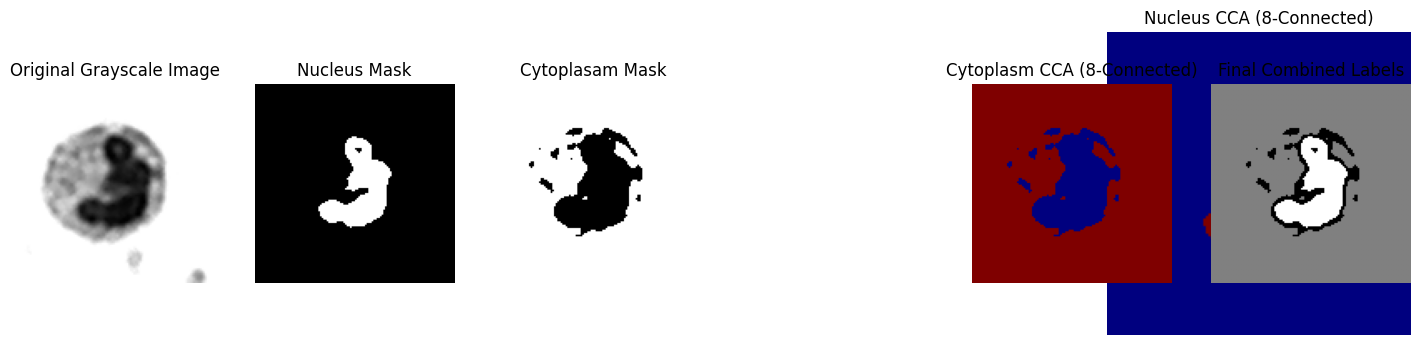

Nucleus Components: 255
Cytoplasm Components: 128
Total Combined Components: 255


In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label
def convert(img, value):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] != 0:
                img[i, j] = value
    return img
# Load the grayscale image
image_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\images\\243.bmp"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
def connected_component_analysis(binary_image):
    """Performs connected component analysis."""
    num_labels, labels = cv2.connectedComponents(binary_image, connectivity=8)
    return num_labels, labels
# Check if the image is loaded correctly
if img is None:
    print("Error: Image not found.")
else:
    # Step 1: Threshold for Nucleus (Assuming Nucleus is Darkest)
    _, nucleus_mask = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY_INV)

    # Step 2: Threshold for Cytoplasm (Intermediate intensity values)
    _, cytoplasm_mask = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    # Step 3: Apply Connected Component Analysis (8-connectivity)
    num_labels_necules, nucleus_labels = connected_component_analysis(nucleus_mask) # 8-connectivity
    nucleus_labels = convert(nucleus_labels, 255)
    print("Nucles : ",np.unique(nucleus_labels))
    num_labels_cytoplasm, cytoplasm_labels = connected_component_analysis(cytoplasm_mask)  # 8-connectivity
    cytoplasm_labels = convert(cytoplasm_labels, 128)
    print("Cytoplasam : ",np.unique(cytoplasm_labels))

    # Step 4: Combine the two labeled images
    combined_labels = nucleus_labels + cytoplasm_labels 
    print("Combined : ",np.unique(combined_labels))
    
    # Step 5: Plot results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 6, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Grayscale Image")
    plt.axis("off")

    plt.subplot(1, 6, 2)
    plt.imshow(nucleus_mask, cmap="gray")
    plt.title("Nucleus Mask")
    plt.axis("off")
    
    plt.subplot(1, 6, 3)
    plt.imshow(cytoplasm_mask, cmap="gray")
    plt.title("Cytoplasam Mask")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(nucleus_labels, cmap="jet")
    plt.title("Nucleus CCA (8-Connected)")
    plt.axis("off")

    plt.subplot(1, 6, 5)
    plt.imshow(cytoplasm_labels, cmap="jet")
    plt.title("Cytoplasm CCA (8-Connected)")
    plt.axis("off")

    plt.subplot(1, 6, 6)
    plt.imshow(combined_labels, cmap="grey")
    plt.title("Final Combined Labels")
    plt.axis("off")

    plt.show()

    # Print number of connected components
    print(f"Nucleus Components: {np.max(nucleus_labels)}")
    print(f"Cytoplasm Components: {np.max(cytoplasm_labels)}")
    print(f"Total Combined Components: {np.max(combined_labels)}")
    

Mean: 161.7760180995475 | Cytoplasm Threshold: 227.23558243259072 | Nucleus Threshold: 96.3164537665043


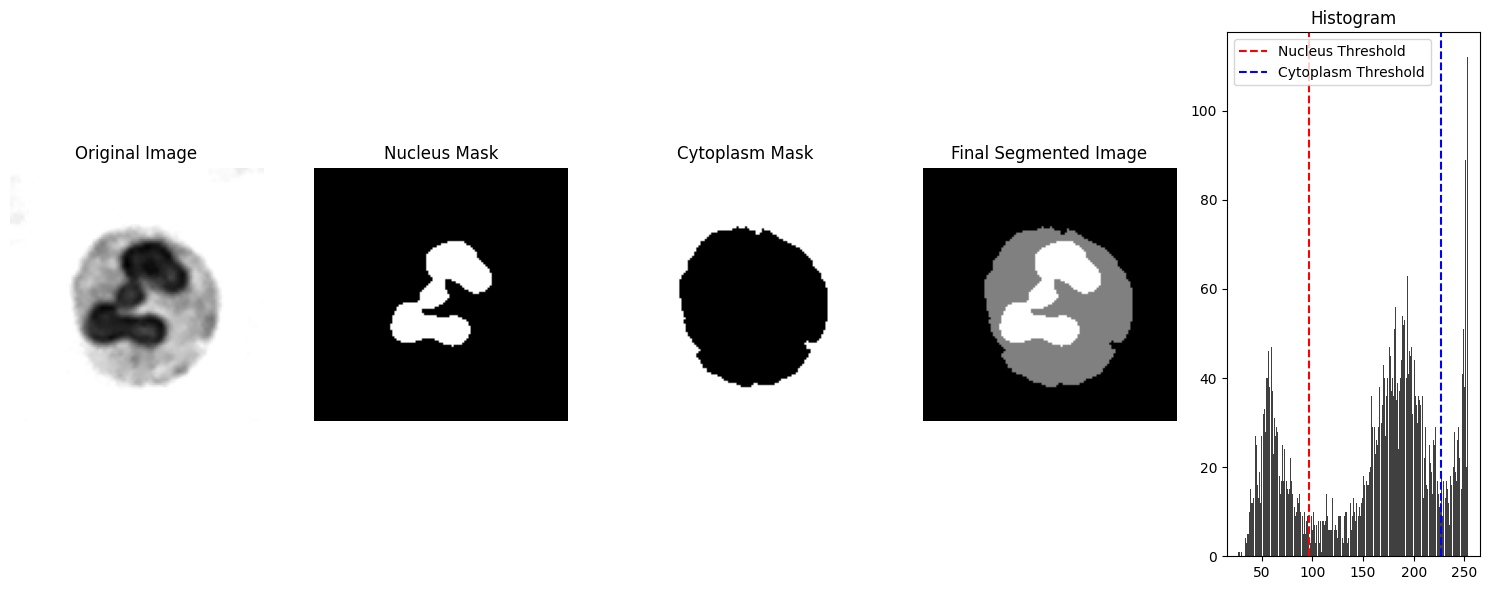

In [165]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the grayscale image
image_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\images\\245.bmp"

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Mask out the white background (255)
valid_pixels = img[img < 255]  # Ignore white background

# Compute mean and standard deviation only on valid pixels
mean_intensity = np.mean(valid_pixels)
std_dev_intensity = np.std(valid_pixels)

# Define dynamic thresholds based on mean and standard deviation
k1, k2 = 1.0, 1.0  # Adjust as needed
nucleus_thresh = mean_intensity - k1 * std_dev_intensity
cytoplasm_thresh = mean_intensity + k2 * std_dev_intensity

print("Mean:", mean_intensity, "| Cytoplasm Threshold:", cytoplasm_thresh, "| Nucleus Threshold:", nucleus_thresh)

# Apply thresholding
_, nucleus_mask = cv2.threshold(img, nucleus_thresh, 255, cv2.THRESH_BINARY_INV)  # Nucleus is white (255)
_, cytoplasm_mask = cv2.threshold(img, cytoplasm_thresh, 255, cv2.THRESH_BINARY)  # Cytoplasm detected

# Create black background masks
nucleus_only = np.zeros_like(img)  # Black Background
nucleus_only[nucleus_mask == 255] = 255  # Nucleus is White

cytoplasm_only = np.zeros_like(img)  # Black Background
cytoplasm_only[cytoplasm_mask == 255] = 128  # Cytoplasm is Gray

# Create final segmented image
segmented = np.zeros_like(img)  # Background Black
segmented[nucleus_only == 255] = 255  # Nucleus White
segmented[cytoplasm_only == 128] = 128  # Cytoplasm Gray
segmented[segmented == 128 ] = 1
segmented[segmented == 0 ] = 128
segmented[segmented == 1 ] = 0

fig, axes = plt.subplots(1, 5, figsize=(15, 6))

# Original Image
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Nucleus Mask
axes[1].imshow(nucleus_only, cmap="gray")
axes[1].set_title("Nucleus Mask")
axes[1].axis("off")

# Cytoplasm Mask
axes[2].imshow(cytoplasm_only, cmap="gray")
axes[2].set_title("Cytoplasm Mask")
axes[2].axis("off")

# Segmented Image
axes[3].imshow(segmented, cmap="gray")
axes[3].set_title("Final Segmented Image")
axes[3].axis("off")

# Histogram
axes[4].hist(valid_pixels.ravel(), bins=256, color="black", alpha=0.75)
axes[4].axvline(nucleus_thresh, color='red', linestyle='dashed', label="Nucleus Threshold")
axes[4].axvline(cytoplasm_thresh, color='blue', linestyle='dashed', label="Cytoplasm Threshold")
axes[4].set_title("Histogram")
axes[4].legend()

plt.tight_layout()
plt.show()


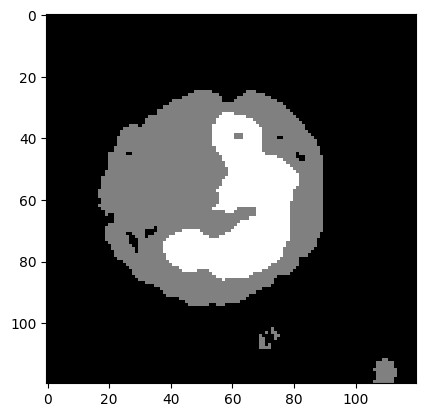

In [121]:
segmented[segmented == 128 ] = 1
segmented[segmented == 0 ] = 128
segmented[segmented == 1 ] = 0
plt.imshow(segmented, cmap="gray")


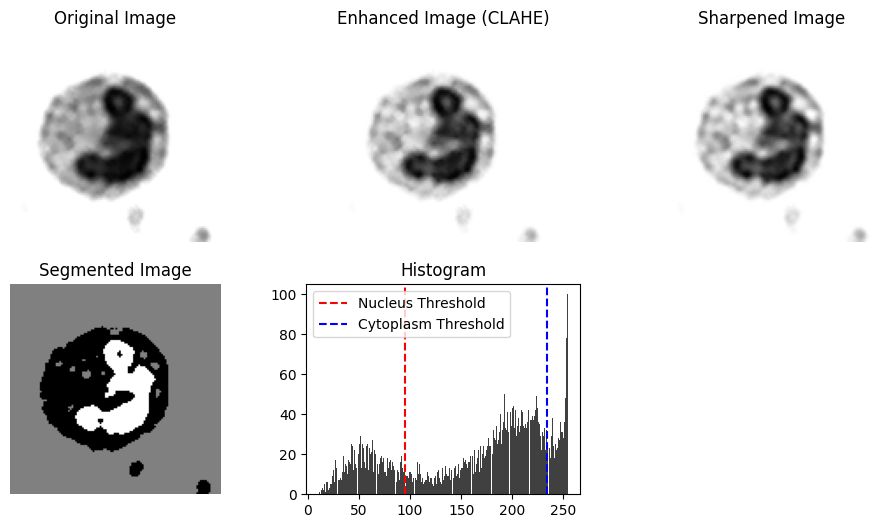

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the grayscale image
image_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\images\\243.bmp"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(img)

# Apply Gaussian Blur to reduce noise
blurred_img = cv2.GaussianBlur(enhanced_img, (5, 5), 0)

# Sharpening Filter
kernel = np.array([[0, -1, 0], 
                   [-1, 5, -1], 
                   [0, -1, 0]])
sharpened_img = cv2.filter2D(blurred_img, -1, kernel)

# Mask out the white background (255)
valid_pixels = sharpened_img[sharpened_img < 255]

# Compute mean and standard deviation on valid pixels
mean_intensity = np.mean(valid_pixels)
std_dev_intensity = np.std(valid_pixels)

# Define dynamic thresholds
k1, k2 = 1.0, 1.0
nucleus_thresh = mean_intensity - k1 * std_dev_intensity
cytoplasm_thresh = mean_intensity + k2 * std_dev_intensity

# Apply thresholding
_, nucleus_mask = cv2.threshold(sharpened_img, nucleus_thresh, 255, cv2.THRESH_BINARY_INV)
_, cytoplasm_mask = cv2.threshold(sharpened_img, cytoplasm_thresh, 255, cv2.THRESH_BINARY)

# Create final segmented image
segmented = np.zeros_like(img)
segmented[cytoplasm_mask == 255] = 128
segmented[nucleus_mask == 255] = 255

# Show results
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Enhanced Image (CLAHE)")
plt.imshow(enhanced_img, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("Sharpened Image")
plt.imshow(sharpened_img, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("Segmented Image")
plt.imshow(segmented, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("Histogram")
plt.hist(valid_pixels.ravel(), bins=256, color="black", alpha=0.75)
plt.axvline(nucleus_thresh, color='red', linestyle='dashed', label="Nucleus Threshold")
plt.axvline(cytoplasm_thresh, color='blue', linestyle='dashed', label="Cytoplasm Threshold")
plt.legend()

plt.show()


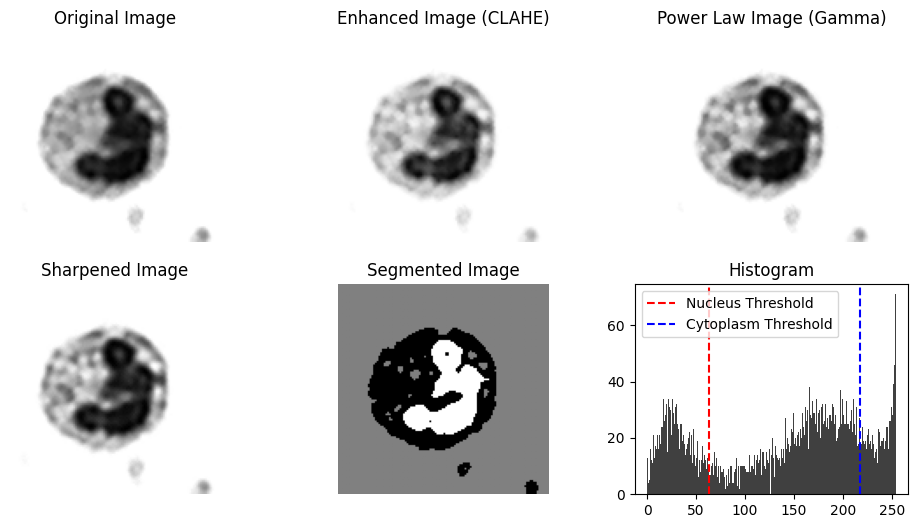

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the grayscale image
image_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\images\\243.bmp"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(img)

# Apply Power Law (Gamma Correction)
gamma = 1.5  # Adjust gamma for better enhancement
power_law_img = np.array(255 * (enhanced_img / 255) ** gamma, dtype=np.uint8)

# Apply Gaussian Blur to reduce noise
blurred_img = cv2.GaussianBlur(power_law_img, (5, 5), 0)

# Sharpening Filter
kernel = np.array([[0, -1, 0], 
                   [-1, 5, -1], 
                   [0, -1, 0]])
sharpened_img = cv2.filter2D(blurred_img, -1, kernel)

# Mask out the white background (255)
valid_pixels = sharpened_img[sharpened_img < 255]

# Compute mean and standard deviation on valid pixels
mean_intensity = np.mean(valid_pixels)
std_dev_intensity = np.std(valid_pixels)

# Define dynamic thresholds
k1, k2 = 1.0, 1.0
nucleus_thresh = mean_intensity - k1 * std_dev_intensity
cytoplasm_thresh = mean_intensity + k2 * std_dev_intensity

# Apply thresholding
_, nucleus_mask = cv2.threshold(sharpened_img, nucleus_thresh, 255, cv2.THRESH_BINARY_INV)
_, cytoplasm_mask = cv2.threshold(sharpened_img, cytoplasm_thresh, 255, cv2.THRESH_BINARY)

# Create final segmented image
segmented = np.zeros_like(img)
segmented[cytoplasm_mask == 255] = 128
segmented[nucleus_mask == 255] = 255

# Show results
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Enhanced Image (CLAHE)")
plt.imshow(enhanced_img, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("Power Law Image (Gamma)")
plt.imshow(power_law_img, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("Sharpened Image")
plt.imshow(sharpened_img, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("Segmented Image")
plt.imshow(segmented, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.title("Histogram")
plt.hist(valid_pixels.ravel(), bins=256, color="black", alpha=0.75)
plt.axvline(nucleus_thresh, color='red', linestyle='dashed', label="Nucleus Threshold")
plt.axvline(cytoplasm_thresh, color='blue', linestyle='dashed', label="Cytoplasm Threshold")
plt.legend()

plt.show()


119.15707685846283 189.49688104219666 48.817272674729


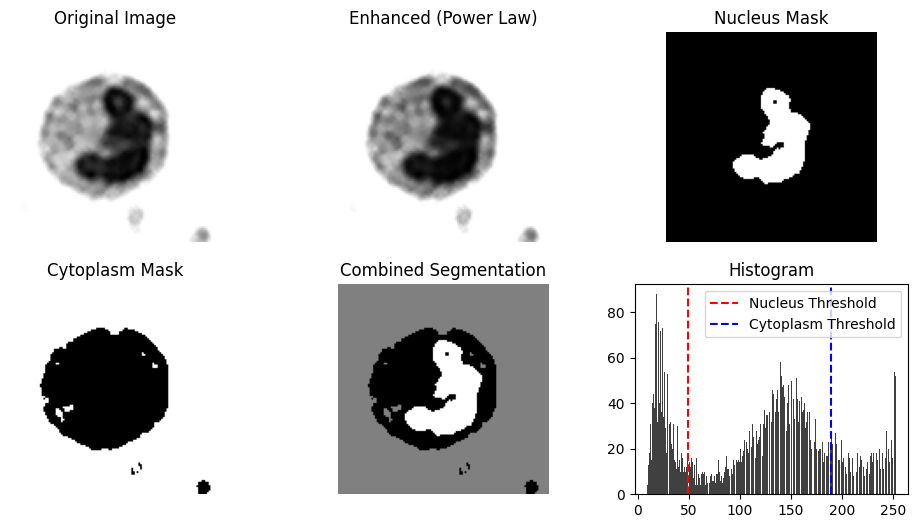

In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the grayscale image
image_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\images\\243.bmp"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Power Law (Gamma Correction)
gamma = 1.5  # Adjust gamma as needed
power_law_img = np.array(255 * (img / 255) ** gamma, dtype=np.uint8)

# Compute mean and standard deviation
valid_pixels = power_law_img[power_law_img < 255]
mean_intensity = np.mean(valid_pixels)
std_dev_intensity = np.std(valid_pixels)

# Define dynamic thresholds
k1, k2 = 1.0, 1.0
nucleus_thresh = mean_intensity - k1 * std_dev_intensity
cytoplasm_thresh = mean_intensity + k2 * std_dev_intensity

# Apply thresholding
_, nucleus_mask = cv2.threshold(power_law_img, nucleus_thresh, 255, cv2.THRESH_BINARY_INV)
_, cytoplasm_mask = cv2.threshold(power_law_img, cytoplasm_thresh, 255, cv2.THRESH_BINARY)
print(mean_intensity, cytoplasm_thresh, nucleus_thresh)

# Create final segmented image
segmented = np.zeros_like(img)
segmented[cytoplasm_mask == 255] = 128
segmented[nucleus_mask == 255] = 255

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Enhanced (Power Law)")
plt.imshow(power_law_img, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("Nucleus Mask")
plt.imshow(nucleus_mask, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("Cytoplasm Mask")
plt.imshow(cytoplasm_mask, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("Combined Segmentation")
plt.imshow(segmented, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.title("Histogram")
plt.hist(valid_pixels.ravel(), bins=256, color="black", alpha=0.75)
plt.axvline(nucleus_thresh, color='red', linestyle='dashed', label="Nucleus Threshold")
plt.axvline(cytoplasm_thresh, color='blue', linestyle='dashed', label="Cytoplasm Threshold")
plt.legend()

plt.show()


119.15707685846283 189.49688104219666 48.817272674729


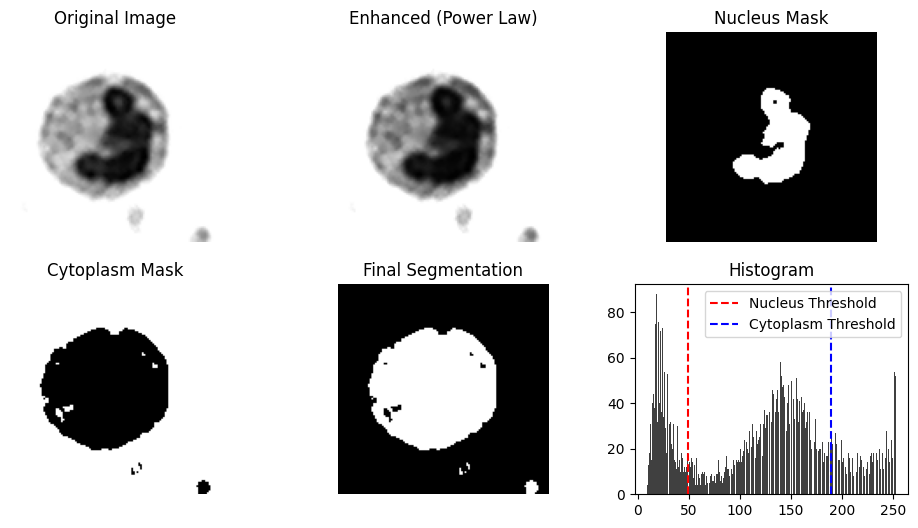

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the grayscale image
image_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\images\\243.bmp"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Power Law (Gamma Correction)
gamma = 1.5  # Adjust gamma as needed
power_law_img = np.array(255 * (img / 255) ** gamma, dtype=np.uint8)

# Compute mean and standard deviation
valid_pixels = power_law_img[power_law_img < 255]
mean_intensity = np.mean(valid_pixels)
std_dev_intensity = np.std(valid_pixels)

# Define dynamic thresholds
k1, k2 = 1.0, 1.0
nucleus_thresh = mean_intensity - k1 * std_dev_intensity
cytoplasm_thresh = mean_intensity + k2 * std_dev_intensity

# Apply thresholding
_, nucleus_mask = cv2.threshold(power_law_img, nucleus_thresh, 255, cv2.THRESH_BINARY_INV)
_, cytoplasm_mask = cv2.threshold(power_law_img, cytoplasm_thresh, 255, cv2.THRESH_BINARY)
print(mean_intensity, cytoplasm_thresh, nucleus_thresh)

# Create final segmented image
segmented = np.zeros_like(img)
segmented[cytoplasm_mask == 255] = 128
segmented[nucleus_mask == 255] = 255

# **Swap background (0) and cytoplasm (128)**
segmented[segmented == 0] = 255  # Temporarily set background to white
segmented[segmented == 128] = 0  # Set cytoplasm to black
segmented[segmented == 255] = 128  # Set background to gray

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Enhanced (Power Law)")
plt.imshow(power_law_img, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("Nucleus Mask")
plt.imshow(nucleus_mask, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("Cytoplasm Mask")
plt.imshow(cytoplasm_mask, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("Final Segmentation")
plt.imshow(segmented, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.title("Histogram")
plt.hist(valid_pixels.ravel(), bins=256, color="black", alpha=0.75)
plt.axvline(nucleus_thresh, color='red', linestyle='dashed', label="Nucleus Threshold")
plt.axvline(cytoplasm_thresh, color='blue', linestyle='dashed', label="Cytoplasm Threshold")
plt.legend()

plt.show()


[  0 128 255]


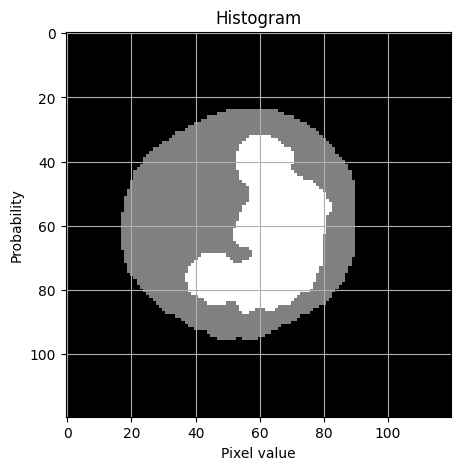

In [67]:
train_images_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\masks\\243.png"
img= cv2.imread(train_images_path, 0)
print(np.unique(img))
plt.figure(figsize=(8, 5))
plt.imshow(img, cmap="gray")
plt.title("Histogram")
plt.xlabel("Pixel value")
plt.ylabel("Probability")
plt.grid()
plt.show()

In [ ]:
def apply_threshold(image):
    """Applies binary thresholding."""
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return binary

def connected_component_analysis(binary_image):
    """Performs connected component analysis."""
    num_labels, labels = cv2.connectedComponents(binary_image, connectivity=8)
    return num_labels, labels


In [5]:
import cv2
import numpy as np
import os

def load_images(image_folder, mask_folder):
    """Loads images and masks from given directories."""
    images, masks = [], []
    
    if os.path.isfile(image_folder) and os.path.isfile(mask_folder):
        image = cv2.imread(image_folder, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_folder, cv2.IMREAD_GRAYSCALE)
        return [image], [mask]
    
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))
    
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        images.append(image)
        masks.append(mask)
    
    return images, masks

def apply_threshold(image, value):
    """Applies binary thresholding."""
    _, binary = cv2.threshold(image, value, 255, cv2.THRESH_BINARY)
    return binary

def connected_component_analysis(binary_image):
    """Performs connected component analysis."""
    num_labels, labels = cv2.connectedComponents(binary_image, connectivity=8)
    return num_labels, labels

def segment_wbc_components(mask):
    """Segments WBC components: nucleus and cytoplasm."""
    nucleus = np.where(mask == 255, 255, 0).astype(np.uint8)
    cytoplasm = np.where(mask == 127, 255, 0).astype(np.uint8)
    return nucleus, cytoplasm

def dice_coefficient(segmented, ground_truth):
    """Calculates Dice Coefficient for evaluation."""
    intersection = np.sum(segmented * ground_truth)
    union = np.sum(segmented) + np.sum(ground_truth)
    return 2.0 * intersection / union if union != 0 else 1.0


In [6]:

# Paths (Change these based on your dataset location)
train_images_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\images"
train_masks_path =  "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\masks"

# Load train images and masks
train_images, train_masks = load_images(train_images_path, train_masks_path)

# Process Training Data
for i, (image, mask) in enumerate(zip(train_images, train_masks)):
    binary_image = apply_threshold(image, )
    num_labels, labels = connected_component_analysis(binary_image)
    nucleus, cytoplasm = segment_wbc_components(mask)
    dice_score = dice_coefficient(nucleus, mask)
    print(f"Train Image {i+1}: Components - {num_labels}, Dice Score: {dice_score:.4f}")


Train Image 1: Components - 3, Dice Score: 0.0024
Train Image 2: Components - 2, Dice Score: 0.0023
Train Image 3: Components - 2, Dice Score: 0.0026
Train Image 4: Components - 2, Dice Score: 0.0026
Train Image 5: Components - 2, Dice Score: 0.0025
Train Image 6: Components - 3, Dice Score: 0.0025
Train Image 7: Components - 2, Dice Score: 0.0024
Train Image 8: Components - 2, Dice Score: 0.0025
Train Image 9: Components - 2, Dice Score: 0.0026
Train Image 10: Components - 2, Dice Score: 0.0025
Train Image 11: Components - 2, Dice Score: 0.0028
Train Image 12: Components - 2, Dice Score: 0.0027
Train Image 13: Components - 2, Dice Score: 0.0026
Train Image 14: Components - 2, Dice Score: 0.0028
Train Image 15: Components - 2, Dice Score: 0.0027
Train Image 16: Components - 2, Dice Score: 0.0027
Train Image 17: Components - 4, Dice Score: 0.0025
Train Image 18: Components - 2, Dice Score: 0.0029
Train Image 19: Components - 2, Dice Score: 0.0028
Train Image 20: Components - 9, Dice Sco

In [ ]:
test_images_path = "path/to/test/images"
test_masks_path = "path/to/test/masks"
# Load test images and masks
test_images, test_masks = load_images(test_images_path, test_masks_path)

dice_scores = {"background": [], "nucleus": [], "cytoplasm": []}

# Process Testing Data
for i, (image, mask) in enumerate(zip(test_images, test_masks)):
    binary_image = apply_threshold(image)
    num_labels, labels = connected_component_analysis(binary_image)
    nucleus, cytoplasm = segment_wbc_components(mask)
    
    dice_scores["nucleus"].append(dice_coefficient(nucleus, mask == 255))
    dice_scores["cytoplasm"].append(dice_coefficient(cytoplasm, mask == 127))
    
    print(f"Test Image {i+1}: Components - {num_labels}")

# Compute Average Dice Score
print("\nDice Coefficients:")
for key in dice_scores:
    print(f"{key}: {np.mean(dice_scores[key]):.4f}")


In [20]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.measure import label

# Define dataset paths
dataset_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment"
train_images_path = os.path.join(dataset_path, "train\\images")
train_masks_path = os.path.join(dataset_path, "train\\masks")
test_images_path = os.path.join(dataset_path, "test\\images")
test_masks_path = os.path.join(dataset_path, "test\\masks")

# Store results
train_results = []
test_results = []

# Function to compute Dice coefficient
def dice_coefficient(pred, gt):
    intersection = np.sum(pred * gt)
    return (2. * intersection) / (np.sum(pred) + np.sum(gt) + 1e-6)  # Avoid division by zero

# **1. Process Training Images - Count Components**
for filename in os.listdir(train_images_path):
    img_path = os.path.join(train_images_path, filename)
    
    # Read image in grayscale
    img = cv2.imread(img_path, 0)
    
    # Threshold to binary
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    # Normalize binary (convert 255 -> 1)
    binary = binary // 255  
    
    # Perform Connected Component Analysis (8-connectivity)
    labeled_img = label(binary, connectivity=2)
    num_components = np.max(labeled_img)
    
    # Store results
    train_results.append({"Image": filename, "Components": num_components})

# **2. Process Test Images - Compute Dice Coefficients**
for filename in os.listdir(test_images_path):
    img_path = os.path.join(test_images_path, filename)
    
    # Change file extension from .bmp to .png for mask
    mask_filename = filename.replace(".bmp", ".png")
    mask_path = os.path.join(test_masks_path, mask_filename)
    
    if not os.path.exists(mask_path):  # Ensure mask exists
        print(f"Mask not found: {mask_path}")  # Debugging print
        continue
    
    # Read image and mask
    img = cv2.imread(img_path, 0)
    mask = cv2.imread(mask_path, 0)

    # Ensure same dimensions
    if img.shape != mask.shape:
        print(f"Resizing mask: {mask_path}")  # Debugging print
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    # Threshold to binary
    _, img_binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    _, mask_binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Normalize binary (convert 255 -> 1)
    img_binary = img_binary // 255
    mask_binary = mask_binary // 255

    # Compute Dice coefficient
    dice_score = dice_coefficient(img_binary, mask_binary)

    # Store results
    test_results.append({"Image": filename, "Dice Coefficient": dice_score})

# Convert lists to Pandas DataFrame
df_train = pd.DataFrame(train_results)
df_test = pd.DataFrame(test_results)

# Display DataFrames
print("Train DataFrame:")
print(df_train)

print("\nTest DataFrame:")
print(df_test)

# Save to CSV files if needed
df_train.to_csv("train_results.csv", index=False)
df_test.to_csv("test_results.csv", index=False)


Train DataFrame:
       Image  Components
0    003.bmp           1
1    004.bmp           2
2    005.bmp           2
3    006.bmp           1
4    007.bmp           1
..       ...         ...
233  236.bmp           1
234  237.bmp           2
235  238.bmp           1
236  239.bmp           1
237  240.bmp           1

[238 rows x 2 columns]

Test DataFrame:
      Image  Dice Coefficient
0   241.bmp          0.312632
1   242.bmp          0.337374
2   243.bmp          0.298878
3   244.bmp          0.318445
4   245.bmp          0.314212
5   246.bmp          0.304087
6   247.bmp          0.336606
7   248.bmp          0.345113
8   249.bmp          0.340867
9   250.bmp          0.318150
10  251.bmp          0.262758
11  252.bmp          0.266835
12  253.bmp          0.239178
13  254.bmp          0.228346
14  255.bmp          0.269855
15  256.bmp          0.232804
16  257.bmp          0.221124
17  258.bmp          0.287371
18  259.bmp          0.222456
19  260.bmp          0.101892
20  261.bmp 

In [21]:
df_test.shape, df_train.shape

((60, 2), (238, 2))

In [24]:
df_test.head()

,Image,Dice Coefficient
0,241.bmp,0.312632
1,242.bmp,0.337374
2,243.bmp,0.298878
3,244.bmp,0.318445
4,245.bmp,0.314212


In [27]:
df_train.head()

,Image,Components
0,003.bmp,1
1,004.bmp,2
2,005.bmp,2
3,006.bmp,1
4,007.bmp,1


In [28]:
df_train["Components"].unique()


array([ 1,  2,  3,  9,  4,  5,  7,  6, 12, 10,  8, 13])

Number of connected components: 7
Labeled Image:
 [[1 1 0 0 0 2]
 [0 0 3 3 0 0]
 [3 3 3 0 4 0]
 [0 0 3 3 0 5]
 [3 3 3 0 6 0]
 [0 0 3 3 0 7]]


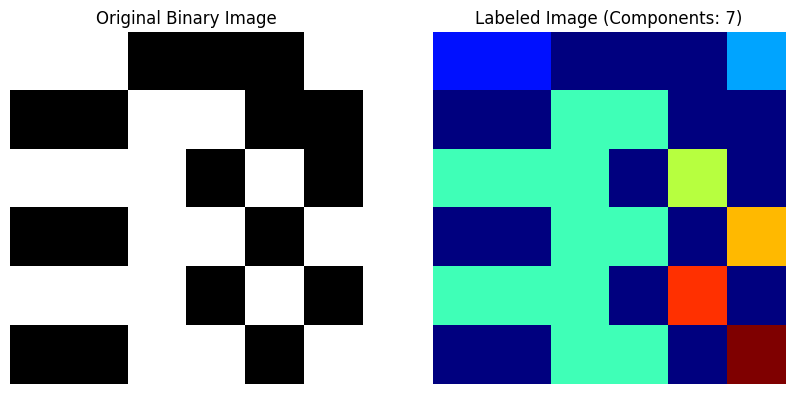

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def cca_opencv(binary_img):
    """Applies Connected Component Analysis using OpenCV"""
    # Convert binary image to uint8 (OpenCV requires uint8 format)
    binary_img = np.array(binary_img, dtype=np.uint8)

    # Perform Connected Component Analysis
    num_labels, labeled_img = cv2.connectedComponents(binary_img, connectivity=4)

    return num_labels - 1, labeled_img  # Exclude background label (0)

def plot_components(img, labeled_img):
    """Plots original image and labeled image"""
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Binary Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(labeled_img, cmap='jet')
    plt.title(f"Labeled Image (Components: {labeled_img.max()})")
    plt.axis("off")

    plt.show()

# Example input binary image
binary_img = np.array([
    [1, 1, 0, 0, 0, 1],
    [0, 0, 1, 1, 0, 0],
    [1, 1, 1, 0, 1, 0],
    [0, 0, 1, 1, 0, 1],
    [1, 1, 1, 0, 1, 0],
    [0, 0, 1, 1, 0, 1]
])

# Run CCA using OpenCV
num_components, labeled_img = cca_opencv(binary_img)

# Print results
print("Number of connected components:", num_components)
print("Labeled Image:\n", labeled_img)

# Plot results
plot_components(binary_img, labeled_img)


Number of connected components: 7
Labeled Image:
 [[1 1 0 0 0 2]
 [0 0 3 3 0 0]
 [3 3 3 0 4 0]
 [0 0 3 3 0 5]
 [3 3 3 0 6 0]
 [0 0 3 3 0 7]]


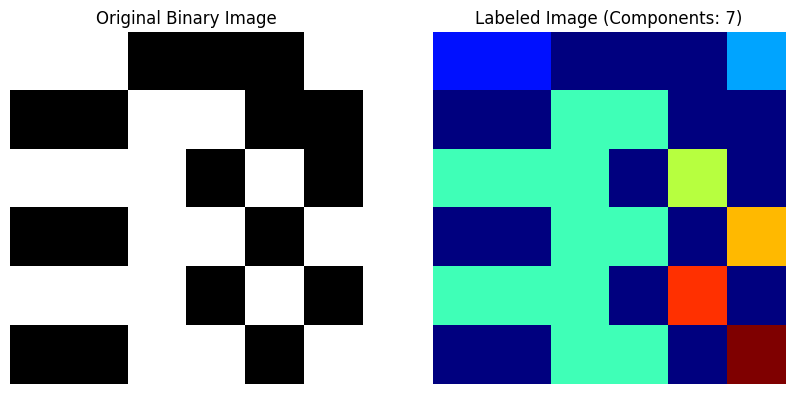

In [14]:
import numpy as np
import matplotlib.pyplot as plt
def get_neighbors_4(x, y, shape):
    """Returns 4-connected neighbors of a pixel"""
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Up, Down, Left, Right
        nx, ny = x + dx, y + dy
        if 0 <= nx < shape[0] and 0 <= ny < shape[1]:  # Check bounds
            neighbors.append((nx, ny))
    return neighbors

def connected_components_4(img):
    """Applies 4-connected CCA on a binary image"""
    rows, cols = img.shape
    label = 1
    labeled_img = np.zeros_like(img, dtype=int)
    visited = np.zeros_like(img, dtype=bool)

    def flood_fill(x, y, label):
        """Recursive DFS flood fill"""
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            if visited[cx, cy]:
                continue
            visited[cx, cy] = True
            labeled_img[cx, cy] = label
            for nx, ny in get_neighbors_4(cx, cy, img.shape):  # 4-connected neighbors
                if img[nx, ny] == 1 and not visited[nx, ny]:
                    stack.append((nx, ny))

    for i in range(rows):
        for j in range(cols):
            if img[i, j] == 1 and not visited[i, j]:  # New component found
                flood_fill(i, j, label)
                label += 1

    num_labels = label - 1  # Total components found
    return num_labels, labeled_img
def get_neighbors_8(x, y, shape):
    """Returns 8-connected neighbors of a pixel"""
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < shape[0] and 0 <= ny < shape[1]:  # Check bounds
                neighbors.append((nx, ny))
    return neighbors

def connected_components_8(img):
    """Applies 8-connected CCA on a binary image"""
    rows, cols = img.shape
    label = 1
    labeled_img = np.zeros_like(img, dtype=int)
    visited = np.zeros_like(img, dtype=bool)

    def flood_fill(x, y, label):
        """Recursive DFS flood fill"""
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            if visited[cx, cy]:
                continue
            visited[cx, cy] = True
            labeled_img[cx, cy] = label
            for nx, ny in get_neighbors_8(cx, cy, img.shape):
                if img[nx, ny] == 1 and not visited[nx, ny]:
                    stack.append((nx, ny))

    for i in range(rows):
        for j in range(cols):
            if img[i, j] == 1 and not visited[i, j]:  # New component found
                flood_fill(i, j, label)
                label += 1

    num_labels = label - 1  # Total components found
    return num_labels, labeled_img

def plot_components(img, labeled_img):
    """Plots original image and labeled image"""
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Binary Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(labeled_img, cmap='jet')
    plt.title(f"Labeled Image (Components: {labeled_img.max()})")
    plt.axis("off")

    plt.show()

# Example input binary image (same as in your case)
binary_img1 = np.array([
    [1, 1, 0, 0, 0, 1],
    [0, 0, 1, 1, 0, 0],
    [1, 1, 1, 0, 1, 0],
    [0, 0, 1, 1, 0, 1],
    [1, 1, 1, 0, 1, 0],
    [0, 0, 1, 1, 0, 1]
])

# Run CCA
num_components, labeled_img1 = connected_components_4(binary_img1)

# Print results
print("Number of connected components:", num_components)
print("Labeled Image:\n", labeled_img1)

# Plot results
plot_components(binary_img1, labeled_img1)
